In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Input##

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import random
from matplotlib.colors import Normalize


In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


##Function##

In [0]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
def apply_mask_1(im, mask, color=1):
    #all tissue color = 1
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked
def get_patch(slide, tumor_mask, lev, x_1, y_1, patch_size_x,patch_size_y):
  #downsample_size
  # downsample_size = 2 ** lev
  # x_1 = x_1*downsample_size
  # y_1 = y_1*downsample_size
  #
  slide_image = read_slide(slide, 
                      x=x_1, 
                      y=y_1, 
                      level=lev,
                      width = patch_size_x,
                      height = patch_size_y)

  mask_image = read_slide(tumor_mask, 
                      x=x_1, 
                      y=y_1, 
                      level=lev,
                      width = patch_size_x,
                      height = patch_size_y)
  
  mask_image = mask_image[:,:,0]
  
  tissue_pixels = list(find_tissue_pixels(slide_image))
  tissue_regions = apply_mask(slide_image,tissue_pixels)
  tissue_regions_1 = apply_mask_1(slide_image,tissue_pixels)
  tissue_mask = tissue_regions_1[:,:,0]
  return slide_image, mask_image, tissue_regions_1, tissue_mask

def plot_patch(name,level_n, patch_center,patch_image, patch_mask, patch_tissue):
  patch_size = patch_image.shape[0]

  offset = int((patch_size-patch_center)/2)
  

  tissue_ratio = np.sum(patch_tissue[:,:,0])/(patch_size**2)
  
  fig, axes = plt.subplots(1,2, figsize=(10,5))
  
  cmap = plt.cm.viridis

 
  v_min, v_max = 0, 1
  colors = Normalize(v_min, v_max)(patch_mask)
  colors = cmap(colors)

  colors[..., -1] = patch_mask
  a = axes[0]
  a.set_title("image:{}".format(name))
  a.imshow(patch_image)

  a.grid(False)


  a = axes[1]
  a.imshow(patch_image)
  a.grid(False)
  a.imshow(colors, cmap='viridis', vmin=v_min, vmax=v_max, alpha=0.8)
  a.plot([offset, offset+patch_center, offset+patch_center, offset, offset],
                [offset, offset, offset+patch_center, offset+patch_center, offset], 'g')
  a.set_title('Caner region in the center, level:{}'.format(level_n))


  plt.show()

def generate_good_bad_cell_location(slide,tumor_mask, lev):
  whole_slide_lev, whole_mask_lev, whole_tissue_regions, whole_tissue_mask = get_patch(slide,
                                                                                        tumor_mask,
                                                                                        lev,
                                                                                        0,
                                                                                        0,
                                                                                        slide.level_dimensions[lev][0],
                                                                                        slide.level_dimensions[lev][1])
  # return the index list of good and bad cell
  bad_cell = []
  good_cell= []
  bad_cell_index = np.nonzero(whole_mask_lev)
  for n in range(len(bad_cell_index[0])):
    a = (bad_cell_index[1][n],bad_cell_index[0][n])
    bad_cell.append(a)
  good_cell_index = np.nonzero(whole_tissue_mask-whole_mask_lev)
  for m in range(len(good_cell_index[0])):
    b = (good_cell_index[1][m],good_cell_index[0][m])
    good_cell.append(b)
  return good_cell, bad_cell

def label_of_patch(mask_image):
  context_size = mask_image.shape[0]
  center = int((context_size-128)/2)
  if not (mask_image[center:context_size-center,center:context_size-center] == 0).all():
    label = 1
  else:
    label = 0
  return label

def single_slide_given_two_level_patch_datas(slide_path,tumor_mask_path,lev,cell_ratio):
  #patch_data_level3 = previous level
  #patch_data_level4 = later level(zoom out)
  patch_data_level3 = []
  patch_data_level4 = []
  patch_label = []
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  #Got the index list of good and bad cell in this level on this slide
  #we choose level 3 and level 4 to get our result 
  good_cell, bad_cell = generate_good_bad_cell_location(slide,tumor_mask, lev)
  bad_cell =  random.sample(bad_cell,140)
  good_cell = random.sample(good_cell,cell_ratio*len(bad_cell))
  for n in range(len(good_cell)):
    (x,y) = good_cell[n]
    downsample_size = 2**(lev)
    x_1 = x*downsample_size
    y_1 = y*downsample_size
    #Get patch for the given level and label
    slide_image_3, mask_image_3, tissue_regions_3, tissue_mask_3 = get_patch(slide, tumor_mask, lev, x_1, y_1,299,299)
    slide_image_4, mask_image_4, tissue_regions_4, tissue_mask_4 = get_patch(slide, tumor_mask, lev+1, x_1, y_1,299,299)
    patch_data_level3.append(tissue_regions_3)
    patch_data_level4.append(tissue_regions_4)
    #Get label
    patch_label.append(label_of_patch(mask_image_3))
  for n in range(len(bad_cell)):
    (x,y) = bad_cell[n]
    downsample_size = 2**(lev)
    x_1 = x*downsample_size
    y_1 = y*downsample_size
    #Get patch and label
    slide_image_3, mask_image_3, tissue_regions_3, tissue_mask_3 = get_patch(slide, tumor_mask, lev, x_1, y_1,299,299)
    slide_image_4, mask_image_4, tissue_regions_4, tissue_mask_4 = get_patch(slide, tumor_mask, lev+1, x_1, y_1,299,299)
    #slide_image, mask_image, tissue_regions, tissue_mask = get_patch(slide, tumor_mask, lev, x_1, y_1,299,299)
    #patch_data.append(tissue_regions)
    patch_data_level3.append(tissue_regions_3)
    patch_data_level4.append(tissue_regions_4)
    #Get label
    patch_label.append(label_of_patch(mask_image_3))
  return patch_data_level3,patch_data_level4,patch_label
  
def mulipy_layer(path_list):
  total_patch_list_level_n = []
  total_patch_list_level_m = []
  total_label_list = [] 
  for fp in path_list:
    slide_path ='/content/drive/My Drive/new_slides/Copy of tumor_' + fp +'.tif'
    tumor_mask_path = '/content/drive/My Drive/new_slides/Copy of tumor_' + fp+'_mask.tif'
    patch_data_level_n,patch_data_level_m,patch_label = single_slide_given_two_level_patch_datas(slide_path,tumor_mask_path,3,1)
    total_patch_list_level_n = total_patch_list_level_n + patch_data_level_n
    total_patch_list_level_m = total_patch_list_level_m + patch_data_level_m
    total_label_list = total_label_list + patch_label
  return total_patch_list_level_n,total_patch_list_level_m,total_label_list

def multiple_datagen(X1, X2, y, preprocess_input):

  X1 = preprocess_input(X1)
  X2 = preprocess_input(X2)
  
  while True:   
      idx = np.random.permutation(X1.shape[0])
      datagen = ImageDataGenerator()
      batches = datagen.flow(X1[idx], y[idx], batch_size=32)
      idx0 = 0
      for batch in batches:
          idx1 = idx0 + batch[0].shape[0]

          yield [batch[0], X2[idx[idx0:idx1]]], batch[1]

          idx0 = idx1
          if idx1 >= X1.shape[0]:
              break
  
def rescale01(x):
    """Rescale RBG values to [0, 1]
    """
    
    x = x.astype(float)
    x /= 255.
    return x
def heat_map(slide_path,tumor_mask_path,model_lev):
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  whole_slide_lev7, whole_mask_lev7, whole_tissue_regions_7, whole_tissue_mask_7 = get_patch(slide,
                                                                                      tumor_mask,
                                                                                      7,
                                                                                      0,
                                                                                      0,
                                                                                      slide.level_dimensions[7][0],
                                                                                      slide.level_dimensions[7][1])
  #get the tissue index in lev7
  tissue_cell = []
  tissue_cell_index = np.nonzero(whole_tissue_mask_7)
  for m in range(len(tissue_cell_index[0])):
    b = (tissue_cell_index[1][m],tissue_cell_index[0][m])
    tissue_cell.append(b)
  #points_number = len(tissue_cell)//10
  tissue_cell = random.sample(tissue_cell,2000)


  #Get the predict patchs 
  predict_patch_data=[]
  for n in range(len(tissue_cell)):
    (x,y) = tissue_cell[n]
    downsample_size = 2**(7)
    x_1 = x*downsample_size - int(299/2)
    y_1 = y*downsample_size - int(299/2)
    #Get patch and label
    slide_image, mask_image, tissue_regions, tissue_mask = get_patch(slide, tumor_mask, model_lev, x_1, y_1,299,299)
    predict_patch_data.append(tissue_regions)
  
  #Get predict value
  X = np.asarray(predict_patch_data)
  X = X/255.0
  pred_value = model.predict(X)
  #plot heatmap
  del predict_patch_data
  heatmap = np.zeros(whole_slide_lev7.shape[:2])
  for n in range(len(tissue_cell)):
    (x,y) = tissue_cell[n]
    # pred_array = np.zeros((2,2))
    # pred_array[:,:] = pred_value[n]
    if pred_value[n] > 0.98:
      heatmap[y-5:y+5, x-5:x+5] = pred_value[n]
  fig, axes = plt.subplots(1,2, figsize=(20,10), dpi=100)
  a = axes[0]
  a.imshow(whole_mask_lev7)
  a = axes[1]
  a.imshow(whole_slide_lev7)
  a.imshow(heatmap, cmap='viridis', alpha=0.8)
  plt.show()
  return heatmap


##Data processing##

In [0]:
trainval_img_list = ['016', '031','064', '075', '078', '084', '094', '096', '101']
test_img_list = ['091']

trainval_patch_images_levn, trainval_patch_images_levm, trainval_patch_labels = mulipy_layer(trainval_img_list)
test_patch_images_levn, test_patch_images_levm, test_patch_labels = mulipy_layer(test_img_list)


In [0]:
trainval_img_list = ['016', '031','064', '075', '078', '084', '094', '096', '101']
test_img_list = ['091']

trainval_patch_images_levn, trainval_patch_images_levm, trainval_patch_labels = mulipy_layer(trainval_img_list)
test_patch_images_levn, test_patch_images_levm, test_patch_labels = mulipy_layer(test_img_list)


total training and validation set size: (2176, 299, 299, 3) lable size: (2176,)
training size: (1740, 299, 299, 3) validation size: (436, 299, 299, 3) (1740,) (436,)


In [0]:
del trainval_patch_images_levn, trainval_patch_images_levm, trainval_patch_labels,
del test_patch_images_levn, test_patch_images_levm, test_patch_labels

In [0]:
model_name = '/content/drive/My Drive/data'
X1_trainval_filename = model_name+'_X1_trainval.npy'
X2_trainval_filename = model_name+'_X2_trainval.npy'
y_trainval_filename = model_name+'_y_trainval.npy'

X1_test_filename = model_name+'_X1_test.npy'
X2_test_filename = model_name+'_X2_test.npy'
y_test_filename = model_name+'_y_test.npy'

np.save(X1_trainval_filename, X1_trainval)
np.save(X2_trainval_filename, X2_trainval)
np.save(y_trainval_filename, y_trainval)
np.save(X1_test_filename, X1_test)
np.save(X2_test_filename, X2_test)
np.save(y_test_filename, y_test)

In [0]:
preprocess_input = rescale01
train_generator = multiple_datagen(X1_train, X2_train, y_train, preprocess_input)
val_generator = multiple_datagen(X1_val, X2_val, y_val, preprocess_input)
test_generator = multiple_datagen(X1_test, X2_test, y_test, preprocess_input)

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, Conv2D,BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.models import Model, Sequential
image_input_1 = Input(shape=(299, 299, 3)) 
image_input_2 = Input(shape=(299, 299, 3)) 


first_lev_model = Sequential()
first_lev_model.add(Conv2D(32, kernel_size=(5, 5), padding='same'))
first_lev_model.add(BatchNormalization())
first_lev_model.add(Activation('relu'))
first_lev_model.add(MaxPooling2D(pool_size=(2, 2)))
first_lev_model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
first_lev_model.add(BatchNormalization())
first_lev_model.add(Activation('relu'))
first_lev_model.add(MaxPooling2D(pool_size=(2, 2)))
first_lev_model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
first_lev_model.add(BatchNormalization())
first_lev_model.add(Activation('relu'))
first_lev_model.add(MaxPooling2D(pool_size=(2, 2)))

second_lev_model = Sequential()
second_lev_model.add(Conv2D(32, kernel_size=(5, 5), padding='same'))
second_lev_model.add(BatchNormalization())
second_lev_model.add(Activation('relu'))
second_lev_model.add(MaxPooling2D(pool_size=(2, 2)))
second_lev_model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
second_lev_model.add(BatchNormalization())
second_lev_model.add(Activation('relu'))
second_lev_model.add(MaxPooling2D(pool_size=(2, 2)))
second_lev_model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
second_lev_model.add(BatchNormalization())
second_lev_model.add(Activation('relu'))
second_lev_model.add(MaxPooling2D(pool_size=(2, 2)))

encoded_image_1 = first_lev_model(image_input_1)
encoded_image_2 = second_lev_model(image_input_2)

merged = tf.keras.layers.concatenate([encoded_image_1, encoded_image_2])
output = Dense(128, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[image_input_1, image_input_2], outputs=output)

In [0]:
model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [0]:
history = model.fit_generator(train_generator, steps_per_epoch=len(X1_train)//32, epochs=14,validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 54 steps, validate for 14 steps
Epoch 1/14
54/54 [==============================] - 29s 539ms/step - loss: 1.5892 - accuracy: 0.5322 - val_loss: 1594.4211 - val_accuracy: 0.6376
Epoch 2/14
54/54 [==============================] - 15s 272ms/step - loss: 1.0746 - accuracy: 0.6054 - val_loss: 2192237.1964 - val_accuracy: 0.4495
Epoch 3/14
54/54 [==============================] - 15s 272ms/step - loss: 0.6979 - accuracy: 0.6552 - val_loss: 65904.8368 - val_accuracy: 0.4495
Epoch 4/14
54/54 [==============================] - 15s 272ms/step - loss: 0.6396 - accuracy: 0.6985 - val_loss: 3140.1097 - val_accuracy: 0.5917
Epoch 5/14
54/54 [==============================] - 15s 272ms/step - loss: 0.5786 - accuracy: 0.7600 - val_loss: 63.1150 - val_accuracy: 0.6124
Epoch 6/14
54/54 [==============================] - 15s 272ms/step - loss: 0.4910 - accuracy: 0.7974

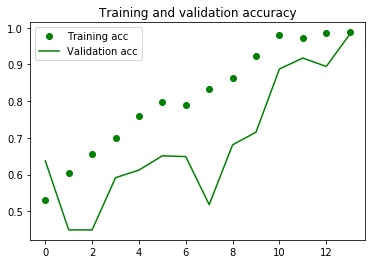

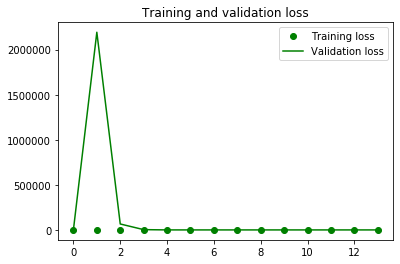

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test loss: %.3f, accuracy: %.3f' % (test_loss, test_acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Test loss: 0.133, accuracy: 0.881


##Final test accuray = 0.881##